<a href="https://colab.research.google.com/github/macwolfz/DZDeepLearningCancerClassification/blob/main/ModeloKerasLabCollab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import tensorflow as tf

In [6]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5



In [7]:
import os
import glob
import pathlib
#from shutil import copyfile
import shutil
from sys import exit
import matplotlib.pyplot as plt
from shutil import copyfile
#import keras.backend.tensorflow_backend as tfback

In [8]:
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [9]:
import pydotplus
import graphviz

In [10]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
num_skipped = 0
for folder_name in ("cancer", "no_cancer"):
    folder_path = os.path.join("/content/gdrive/MyDrive/Collab Notebooks/LungCells/seg_train", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)
#

Deleted 0 images


In [11]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/gdrive/MyDrive/Collab Notebooks/LungCells/seg_train",
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/gdrive/MyDrive/Collab Notebooks/LungCells/seg_train",
    validation_split=0.2,
    subset="validation",
    #seed=1337,
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
)


Found 7226 files belonging to 2 classes.
Using 5781 files for training.
Found 7226 files belonging to 2 classes.
Using 1445 files for validation.


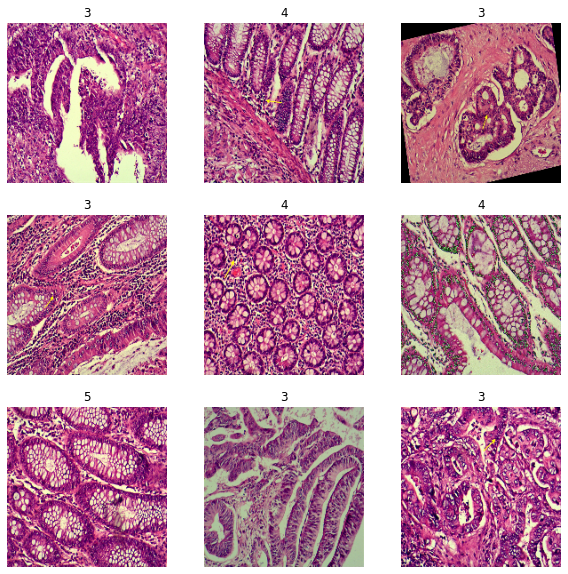

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [12]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

In [13]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)


In [18]:
epochs = 50
callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/50
181/181 [==============================] - 1409s 8s/step - loss: 0.5133 - accuracy: 0.7718 - val_loss: 1.4763 - val_accuracy: 0.5349
Epoch 2/50
181/181 [==============================] - 143s 755ms/step - loss: 0.2356 - accuracy: 0.9132 - val_loss: 1.9101 - val_accuracy: 0.5349
Epoch 3/50
181/181 [==============================] - 148s 784ms/step - loss: 0.1763 - accuracy: 0.9345 - val_loss: 1.5134 - val_accuracy: 0.5349
Epoch 4/50
181/181 [==============================] - 147s 783ms/step - loss: 0.1365 - accuracy: 0.9518 - val_loss: 0.1927 - val_accuracy: 0.9495
Epoch 5/50
181/181 [==============================] - 148s 785ms/step - loss: 0.1315 - accuracy: 0.9536 - val_loss: 0.2805 - val_accuracy: 0.9190
Epoch 6/50
181/181 [==============================] - 148s 786ms/step - loss: 0.1283 - accuracy: 0.9573 - val_loss: 0.3649 - val_accuracy: 0.8422
Epoch 7/50
181/181 [==============================] - 149s 789ms/step - loss: 0.1172 - accuracy: 0.9585 - val_loss: 0.1286 - v

**Load** Epoch 48/50
206/206 [==============================] - 121s 585ms/step - loss: 0.0386 - accuracy: 0.9853 - val_loss: 0.0577 - val_accuracy: 0.9787


In [15]:
from tensorflow.keras.models import load_model
new_model = load_model('/content/gdrive/MyDrive/Collab Notebooks/Saved_Models/Keras/ep47.h5')
#new_model.summary()
#new_model.get_weights()

In [16]:
img = keras.preprocessing.image.load_img(
    "/content/gdrive/MyDrive/Collab Notebooks/LungCells/seg_pred/seg_pred/114_non_cancer_test.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = new_model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent Cancer and %.2f percent No Cancer."
    % (100 * (1 - score), 100 * score)
)

This image is 0.11 percent Cancer and 99.89 percent No Cancer.


In [17]:
pred_path='/content/gdrive/MyDrive/Collab Notebooks/LungCells/seg_pred/seg_pred'
#categories
images_path=glob.glob(pred_path+'/*.jpg')

In [18]:
target_cancer = "/content/gdrive/MyDrive/Collab Notebooks/LungCells/Output/cancer"
target_no_cancer = "/content/gdrive/MyDrive/Collab Notebooks/LungCells/Output/no_cancer"
target_others = "/content/gdrive/MyDrive/Collab Notebooks/LungCells/Output/not_Clear"

In [ ]:
num_cancer = 0
num_no_cancer = 0
num_otros = 0
predictions={}

for i in images_path:
    img = keras.preprocessing.image.load_img(
    i, target_size=image_size)
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis
    predictions = new_model.predict(img_array)
    #predictions = model.predict(img_array)
    score = predictions[0]
    res = i.partition(pred_path)[2]
    print(res[1:])
    if "non_cancer" in res and (100 * score)>50:
        print("no tiene cancer")
        num_no_cancer += 1
        # adding exception handling
        try:
            copyfile(i, target_no_cancer+res)
        except IOError as e:
            print("Unable to copy file. %s" % e)
            exit(1)
        except:
            print("Unexpected error:", sys.exc_info())
            exit(1)
            
    elif "non_cancer" not in res and (100*(1-score))> 50:
        print("tiene cancer")
        num_cancer+=1
        # adding exception handling
        try:
            copyfile(i, target_cancer+res)
        except IOError as e:
            print("Unable to copy file. %s" % e)
            exit(1)
        except:
            print("Unexpected error:", sys.exc_info())
            exit(1)
    else:
        print("ERROR")
        print(100*score)
        print(100*(1-score))
        num_otros += 1
        # adding exception handling
        try:
            copyfile(i, target_others+res)
        except IOError as e:
            print("Unable to copy file. %s" % e)
            exit(1)
        except:
            print("Unexpected error:", sys.exc_info())
            exit(1)
                               
    print(
    "This image is %.2f percent Cancer and %.2f percent No Cancer."
    % (100 * (1 - score), 100 * score)
    )
    print("\n")
   


In [19]:
print("有肺癌的人：",num_cancer)
print("没有肺癌的人：",num_no_cancer)
print("另外的图片：",num_otros)

NameError: ignored

In [25]:
import glob, os, os.path

filelist = glob.glob(os.path.join("/content/gdrive/MyDrive/Collab Notebooks/LungCells/Output/cancer", "*.jpg"))
for f in filelist:
    os.remove(f)
filelist = glob.glob(os.path.join("/content/gdrive/MyDrive/Collab Notebooks/LungCells/Output/no_cancer", "*.jpg"))
for f in filelist:
    os.remove(f)
filelist = glob.glob(os.path.join("/content/gdrive/MyDrive/Collab Notebooks/LungCells/Output/not_Clear", "*.jpg"))
for f in filelist:
    os.remove(f)



In [21]:
test_loss, test_acc = new_model.evaluate(val_ds, verbose=2)
print('\nTest Accuracy', test_acc)

46/46 - 612s - loss: 0.0312 - accuracy: 0.9910

Test Accuracy 0.9910034537315369


In [26]:
#Start
train_data_path = 'F://data//Train'
test_data_path = 'F://data//Validation'
img_rows = 150
img_cols = 150
epochs = 30
batch_size = 32
num_of_train_samples = 3000
num_of_test_samples = 600

#Image Generator
train_datagen = ImageDataGenerator(rescale=1. / 255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(train_data_path,
                                                    target_size=(img_rows, img_cols),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(test_data_path,
                                                        target_size=(img_rows, img_cols),
                                                        batch_size=batch_size,
                                                        class_mode='categorical')

AttributeError: ignored

In [32]:
import numpy as np
from keras import backend as K
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

In [46]:
#Start
train_data_path = '/content/gdrive/MyDrive/Collab Notebooks/LungCells/divTrain/train'
test_data_path = '/content/gdrive/MyDrive/Collab Notebooks/LungCells/divTrain/test'
img_rows = 180
img_cols = 180
epochs = 30
batch_size = 32
num_of_train_samples = 4334
num_of_test_samples = 1448

#Image Generator
train_datagen = ImageDataGenerator(rescale=1. / 255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(train_data_path,
                                                    target_size=(img_rows, img_cols),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(test_data_path,
                                                        target_size=(img_rows, img_cols),
                                                        batch_size=batch_size,
                                                        class_mode='categorical')

img_height, img_width = (224,224)
batch_size = 32

train_data_dir = r"/content/gdrive/MyDrive/Collab Notebooks/LungCells/divTrain/train"
test_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size = 1, # aqui va 1 siempre
    class_mode="categorical",
    subset='validation') #set as validaton data
    

Found 4334 images belonging to 2 classes.
Found 1448 images belonging to 2 classes.
Found 0 images belonging to 2 classes.


In [39]:
#Confution Matrix and Classification Report
Y_pred = model.predict_generator(validation_generator , num_of_test_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator .classes, y_pred))
print('Classification Report')
target_names = ['cancer', 'no_cancer']
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Confusion Matrix
[[783   0]
 [665   0]]
Classification Report
              precision    recall  f1-score   support

      cancer       0.54      1.00      0.70       783
   no_cancer       0.00      0.00      0.00       665

    accuracy                           0.54      1448
   macro avg       0.27      0.50      0.35      1448
weighted avg       0.29      0.54      0.38      1448



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [44]:
img_height, img_width = (224,224)
batch_size = 32

train_data_dir = r"/content/gdrive/MyDrive/Collab Notebooks/LungCells/divTrain/train"
test_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size = 1, # aqui va 1 siempre
    class_mode="categorical",
    subset='validation') #set as validaton data

Found 0 images belonging to 2 classes.


In [ ]:
#!pip install seaborn
#script para la matriz de confusion
import pandas as pd
import seaborn as sn
import tensorflow as tf

model = tf.keras.models.load_model('/content/gdrive/MyDrive/Collab Notebooks/Saved_Models/Res Net50_Lung/ModeloResNet50ResNet50_LungCancerCell.h5')
filenames = test_generator.filenames
nb_samples = len(test_generator)
y_prob=[]
y_act=[]
test_generator.reset()
for _ in range(nb_samples):
    X_test, Y_test = test_generator.next()
    y_prob.append(model.predict(X_test))
    y_act.append(Y_test)
    
predicted_class = [list(train_generator.class_indices.keys())[i.argmax()] for i in y_prob]
actual_class = [list(train_generator.class_indices.keys())[i.argmax()] for i in y_act]

out_df = pd.DataFrame(np.vstack([predicted_class, actual_class]).T, columns=['predicted_class','actual_class'])
confusion_matrix = pd.crosstab(out_df['actual_class'],out_df['predicted_class'],rownames=['Actual'], colnames=['predicted'])

sn.heatmap(confusion_matrix, cmap='Blues', annot=True, fmt='d')
plt.show()
print('test accuracy : {}'.format((np.diagonal(confusion_matrix).sum()/confusion_matrix.sum().sum()*10)))